# Density Estimation using Planar Flow on UCI datasets

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from data.dataset_loader import load_and_preprocess_uci
from normalizingflows.flow_catalog import PlanarFlow
from utils.train_utils import train_density_estimation, nll

tfd = tfp.distributions
tfb = tfp.bijectors
tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [2]:
tf.test.is_gpu_available()

True

In [3]:
# parameters
batch_size = 256
dataset = 'gas'
layers = 4
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(500)
exp_number = 1
uci_trainsizes = {"power": 1659917,
                 "gas": 852174,
                 "hepmass": 315123,
                 "miniboone": 29556,
                 "bsds300": 1000000}
trainsize = uci_trainsizes[dataset]

In [4]:
batched_train_data, batched_val_data, batched_test_data = load_and_preprocess_uci(dataset, batch_size=batch_size)

/nfs/homedirs/rinder/project-8/data/uci_classes.py:146: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  B = A.as_matrix().sum(axis=1)
/nfs/homedirs/rinder/project-8/data/uci_classes.py:168: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = self.load_data_and_clean(file).as_matrix()


In [5]:
# assign a normal distribution
sample_batch = next(iter(batched_train_data))
input_shape = sample_batch.shape[1]
print(input_shape)

base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=input_shape, dtype=tf.float32))

8


### Create a Planar Flow

In [6]:
# create a flow
bijectors = []

for i in range(0, layers):
    bijectors.append(PlanarFlow(input_dimensions=input_shape, case="density_estimation"))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

planar_flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

In [7]:
# ensure invertibility
for bijector in planar_flow.bijector.bijectors:
    bijector._u()
print(len(planar_flow.trainable_variables))

12


In [8]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [9]:
checkpoint_directory = "{}/tmp_{}".format(dataset, str(hex(random.getrandbits(32))))
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=planar_flow)

In [ ]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 25  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    
    batched_train_data.shuffle(buffer_size=trainsize, reshuffle_each_iteration=True)
    batch_train_losses = []
    for batch in batched_train_data:
        batch_loss = train_density_estimation(planar_flow, opt, batch)
        batch_train_losses.append(batch_loss)

        # ensure that w.T * u > -1 (invertibility)
        for bijector in planar_flow.bijector.bijectors:
            bijector._u()
            
    train_loss = tf.reduce_mean(batch_train_losses)

    if i % int(1) == 0:
        batch_val_losses = []
        for batch in batched_val_data:
            batch_loss = nll(planar_flow, batch)
            batch_val_losses.append(batch_loss)
                
        val_loss = tf.reduce_mean(batch_val_losses)
        
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i

            checkpoint.write(file_prefix=checkpoint_prefix)

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

train_time = time.time() - t_start

In [ ]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()

test_losses = []
for batch in batched_test_data:
    batch_loss = nll(planar_flow, batch)
    test_losses.append(batch_loss)
    
test_loss = tf.reduce_mean(test_losses)

test_time = time.time() - t_start

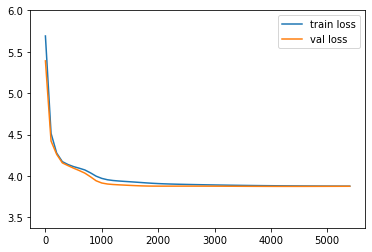

In [12]:
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()